In [1]:
# Download and Install Commpy
!git clone --quiet https://github.com/datlife/CommPy
!cd CommPy && git checkout master && python setup.py install > /dev/null
print('CommPy library is installed.')

# Download and Install DeepCom
!git clone --quiet https://github.com/datlife/radioml
!mv radioml ./backup && mv backup/radioml radioml

# Import local module `deepcom`
import sys
sys.path.append('radioml')
print('radioml is installed.')

fatal: destination path 'CommPy' already exists and is not an empty directory.
Already on 'master'
Your branch is up-to-date with 'origin/master'.
zip_safe flag not set; analyzing archive contents...
commpy.channelcoding.tests.__pycache__.test_ldpc.cpython-36: module references __file__
CommPy library is installed.
fatal: destination path 'radioml' already exists and is not an empty directory.
radioml is installed.


In [0]:
import multiprocessing as mp
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

# For visualization
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

## Define Hyper-parameters

In [0]:
NUM_EXAMPLES = 200000 # 200k examples
BLOCK_LEN = 100
SNR_MAX   = 10.0 # [0.5,1] 100 
SNR       = SNR_MAX 

modem = QAMModem(4)  # Constellation  QAM16
trellis = Trellis(memory   = np.array([2]), 
                  g_matrix = np.array([[0o7, 0o5]]) , 
                  feedback = 0o7)

In [0]:
def generate_signal_over_awgn(modem, block_length=100, snr_dB=15.0):
    message_bits   = np.random.randint(0, 2, block_length)
    encoded_bits   = cp.channelcoding.conv_encode(message_bits, trellis)
    modulated_bits = modem.modulate(encoded_bits)
    corrupted_bits = cp.channels.awgn(modulated_bits, snr_dB, rate=1/2)
    
    return message_bits, modulated_bits, corrupted_bits

def signal_generator(modulation_scheme, num_examples, block_length, snr_dB, 
                     seed=2018):
    np.random.seed(seed)
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.starmap(generate_signal_over_awgn,
                iterable=[(modulation_scheme, block_length, snr_dB) \
                          for i in range(num_examples)])
        orignal_msg_bits, moded_bits, noisy_outputs = zip(*result)
    np.random.seed()
    return (np.array(orignal_msg_bits), np.array(moded_bits), np.array(noisy_outputs))

## Train a RNN to estimate original message over noisy AWGN channel.

### Split data into training/dev/test

* Dev and Test set should have similar distribution.
* Split into 80/10/10.
* Adopt from : https://cs230-stanford.github.io/train-dev-test-split.html

In [5]:
import random 

# Generate data for training
original_bits, clean_signals, noisy_signals = signal_generator(modem, NUM_EXAMPLES, BLOCK_LEN, SNR)

# Split data into train/dev/test
dataset = list(zip(noisy_signals, original_bits))

# Shuffle Before splitting the data
# random.shuffle(dataset)
split1 = int(0.8 * len(dataset))
split2 = int(0.9 * len(dataset))
train_set = dataset[:split1]
dev_set = dataset[split1:split2]
test_set = dataset[split2:]

print(len(train_set), len(dev_set), len(test_set))

160000 20000 20000


In [6]:
def get_trainable_data(x, y):
    """Encode complex numbers to trainable data and one_hot labels"""
    x = np.array(x)[:, :100]
    y = np.array(y)
    x = np.stack((x.real, x.imag), axis=-1)
    y = np.expand_dims(y, -1)  # (batch, block_length, 1)
    return x, y

x_train, y_train = zip(*train_set)
x_dev, y_dev = zip(*dev_set)
x_test, y_test = zip(*test_set)

X_train, Y_train = get_trainable_data(x_train, y_train)
X_dev, Y_dev = get_trainable_data(x_dev, y_dev)
X_test, Y_test = get_trainable_data(x_test, y_test)

print('Training data')
print('Trainable data:', X_train.shape, X_dev.shape, X_test.shape)
print('Groundtruths  :', Y_train.shape, Y_dev.shape, Y_test.shape)

Training data
Trainable data: (160000, 100, 2) (20000, 100, 2) (20000, 100, 2)
Groundtruths  : (160000, 100, 1) (20000, 100, 1) (20000, 100, 1)


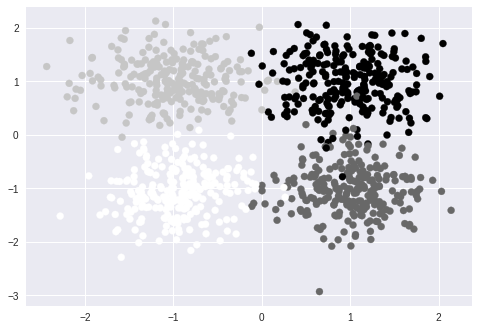

In [7]:
inputs = noisy_signals.flatten()[0:1000]
_, groundtruths = np.unique(clean_signals, return_inverse=True)
plt.scatter(np.real(inputs), np.imag(inputs), c=groundtruths[0:1000])

###  Esimate optimal performance using baseline


In [8]:
from radioml.radio_receivers import ModularReceiver
from radioml.demodulators import ClassicDemodulator
from radioml.decoders import ViterbiDecoder
from radioml.utils import get_ber_bler

classic_demod   = ClassicDemodulator(modem)
viterbi_decoder = ViterbiDecoder(trellis, tb_depth=15, decoding_type='hard')

baseline_receiver = ModularReceiver(classic_demod, viterbi_decoder)

with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_dev])

ber, bler        = get_ber_bler(np.array(baseline_estimated)[:, :100], 
                                      y_dev)
print('Optimal BER: %.4f' % ber)
print('Optimal BLER: %.5f' % bler)

Optimal BER: 0.0003
Optimal BLER: 0.01625


### Define a Recurrent  Neural network for estimating orginal message

In [9]:
## Simple Classification
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional, TimeDistributed
tf.keras.backend.clear_session()

num_hidden_layers = 2
num_hidden_units = 400
dropout_rate = 0.3


inputs  = Input(shape=(None, 2))
x = inputs
for _ in range(num_hidden_layers):
    x = Bidirectional(GRU(
        units=num_hidden_units,
        return_sequences=True,
        recurrent_dropout=dropout_rate))(x)
    x = BatchNormalization()(x)
    
outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 800)         967200    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 800)         3200      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 800)         2882400   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 800)         3200      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           801       
Total params: 3,856,801
Trainable params: 3,853,601
Non-trainable params: 3,200
______________________________________________________________

In [10]:
def BER(y, y_pred):
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.reduce_sum(hamming_distances) / tf.size(y)

def BLER(y, y_pred):
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int64)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.count_nonzero(tf.reduce_sum(hamming_distances, axis=1)) / num_blocks_per_batch

model.compile('adam','mse', metrics=[BER, BLER])
model.fit(X_train, Y_train, 
          validation_data=(X_dev, Y_dev), 
          epochs=3, batch_size=512)

Train on 160000 samples, validate on 20000 samples
Epoch 1/3
160000/160000 [==============================] - 626s 4ms/step - loss: 0.0134 - BER: 0.0167 - BLER: 0.6750 - val_loss: 0.0148 - val_BER: 0.0116 - val_BLER: 0.6782
Epoch 2/3
 73728/160000 [============>.................] - ETA: 5:21 - loss: 0.0015 - BER: 0.0019 - BLER: 0.1596

160000/160000 [==============================] - 621s 4ms/step - loss: 0.0011 - BER: 0.0014 - BLER: 0.1236 - val_loss: 6.2392e-04 - val_BER: 7.9650e-04 - val_BLER: 0.0728
Epoch 3/3
144896/160000 [==========================>...] - ETA: 56s - loss: 5.7237e-04 - BER: 7.1541e-04 - BLER: 0.0649

160000/160000 [==============================] - 621s 4ms/step - loss: 5.5788e-04 - BER: 6.9625e-04 - BLER: 0.0632 - val_loss: 3.5007e-04 - val_BER: 4.4450e-04 - val_BLER: 0.0398


In [11]:
with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_test])

ber, bler = get_ber_bler(np.array(baseline_estimated)[:, :100], y_test)
print('Optimal BER: %.4f' % ber)
print('Optimal BLER: %.5f' % bler)

Optimal BER: 0.0003
Optimal BLER: 0.01670


In [12]:
# _, ber, bler = model.evaluate(X_test, Y_test)
predictions = model.predict(X_test, batch_size=512)
estimated = np.squeeze(predictions, -1).round()

ber, bler = get_ber_bler(np.array(estimated), y_test)
print('BER: %f' % ber)
print('BLER: %f' % bler)

BER: 0.000432
BLER: 0.038950


In [37]:
model.fit(X_train, Y_train, 
          validation_data=(X_dev, Y_dev), 
          epochs=5, batch_size=512)

Train on 160000 samples, validate on 20000 samples
Epoch 1/5
160000/160000 [==============================] - 621s 4ms/step - loss: 1.0307e-04 - BER: 1.2675e-04 - BLER: 0.0106 - val_loss: 6.3797e-05 - val_BER: 8.1000e-05 - val_BLER: 0.0065
Epoch 2/5
 65536/160000 [===========>..................] - ETA: 5:52 - loss: 2.6235e-04 - BER: 3.2852e-04 - BLER: 0.0260

160000/160000 [==============================] - 621s 4ms/step - loss: 1.8797e-04 - BER: 2.3563e-04 - BLER: 0.0187 - val_loss: 5.3836e-05 - val_BER: 6.0000e-05 - val_BLER: 0.0046
Epoch 3/5
 12288/160000 [=>............................] - ETA: 9:10 - loss: 9.3319e-05 - BER: 1.1393e-04 - BLER: 0.0094

KeyboardInterrupt: ignored

In [47]:
!pip install pydot

    100% |████████████████████████████████| 133kB 5.7MB/s 
  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /content/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 800)         967200    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 800)         3200      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 800)         2882400   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 800)         3200      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           801       
Total params: 3,856,801
Trainable params: 3,853,601
Non-trainable params: 3,200
______________________________________________________________

In [15]:
# _, ber, bler = model.evaluate(X_test, Y_test)
predictions = model.predict(X_test, batch_size=512)
estimated = np.squeeze(predictions, -1).round()

ber, bler = get_ber_bler(np.array(estimated), y_test)
print('BER: %f' % ber)
print('BLER: %f' % bler)

BER: 0.000118
BLER: 0.009400


In [0]:
model.save('end2end.hdf5')

In [0]:
from radioml.radio_receivers import Receiver
from radioml.radio_receivers import ModularReceiver
from radioml.decoders import ViterbiDecoder, NeuralDecoder

from tensorflow.keras.models import load_model
import radioml.utils as utils

class End2EndReceiver(Receiver):
    """End-to-End Receiver."""
    def __init__(self, model, block_length):
        super(End2EndReceiver, self).__init__()
        self.block_length = block_length
        self.model = load_model(model, compile=False)

    def __call__(self, noisy_inputs, batch_size):
        predictions = self.model.predict(self._preprocess_fn(noisy_inputs), batch_size)
        return np.squeeze(predictions, -1).round()


    def _preprocess_fn(self, complex_inputs):
        """Encode complex inputs to 2D ndarray inputs"""
        x = np.stack((np.array(complex_inputs).real,
                      np.array(complex_inputs).imag),
                      axis=-1)
        return x.reshape((-1, self.block_length, 2))   



classic_demod   = ClassicDemodulator(modem)
viterbi_decoder = ViterbiDecoder(trellis, tb_depth=15, decoding_type='hard')

baseline_receiver = ModularReceiver(classic_demod, viterbi_decoder)
end2end_receiver = End2EndReceiver('end2end.hdf5', block_length=100)

In [44]:
import time
class Params:
    SNR_RANGE = [0.0, 3.0, 5.0, 7.0, 9.0, 10.0, 11.0, 13.0]
    NUM_SAMPLES = 2000
    BLOCK_LENGTH = 100
    BPSK, QPSK, QAM16, QAM64 = 2, 4, 16, 64
    
    
ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    print('SNR_dB = %f' % snr)
    
    (original_bits, clean_signals, noisy_signals) = signal_generator(
        modem,
        Params.NUM_SAMPLES, 
        Params.BLOCK_LENGTH, 
        snr)
    
    # ####################################
    # Run Baseline/Neral Receiver
    # ####################################
    t1 = time.time()
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimated = pool.map(baseline_receiver, [i for i in noisy_signals])
    t2 = time.time()
    nn_estimated = end2end_receiver(np.array(noisy_signals)[:, :100], 128)
    t3 = time.time()
    # ####################################
    # Measure Accuracy / error
    # #################################### 
    # For decoder
    ber, bler        = utils.get_ber_bler(np.array(baseline_estimated)[:, :100], 
                                          original_bits)
    nn_ber, nn_bler  = utils.get_ber_bler(nn_estimated, original_bits)
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])
    
    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:.5f}'.format(nn_ber, nn_bler, t2 - t1))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:.5f}'.format(ber, bler, t3-t2))

SNR_dB = 0.000000
	[Modular]  Ber = 0.23604000 | Bler =1.00000000 - 41.06021
	[Baseline] Ber = 0.28425000 | Bler =1.00000000 - 5.12924
SNR_dB = 3.000000
	[Modular]  Ber = 0.12044000 | Bler =0.99800000 - 41.26327
	[Baseline] Ber = 0.16614000 | Bler =0.99900000 - 5.13879
SNR_dB = 5.000000
	[Modular]  Ber = 0.04434000 | Bler =0.91600000 - 40.85605
	[Baseline] Ber = 0.07432000 | Bler =0.91900000 - 5.12958
SNR_dB = 7.000000
	[Modular]  Ber = 0.00813000 | Bler =0.37500000 - 40.95719
	[Baseline] Ber = 0.01539000 | Bler =0.39800000 - 5.15360
SNR_dB = 9.000000
	[Modular]  Ber = 0.00052000 | Bler =0.03400000 - 40.95396
	[Baseline] Ber = 0.00144000 | Bler =0.06000000 - 5.12299
SNR_dB = 10.000000
	[Modular]  Ber = 0.00004000 | Bler =0.00300000 - 40.75341
	[Baseline] Ber = 0.00054000 | Bler =0.02500000 - 5.10981
SNR_dB = 11.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000 - 41.25622
	[Baseline] Ber = 0.00010000 | Bler =0.00700000 - 5.14927
SNR_dB = 13.000000
	[Modular]  Ber = 0.00000000 | Ble

[]

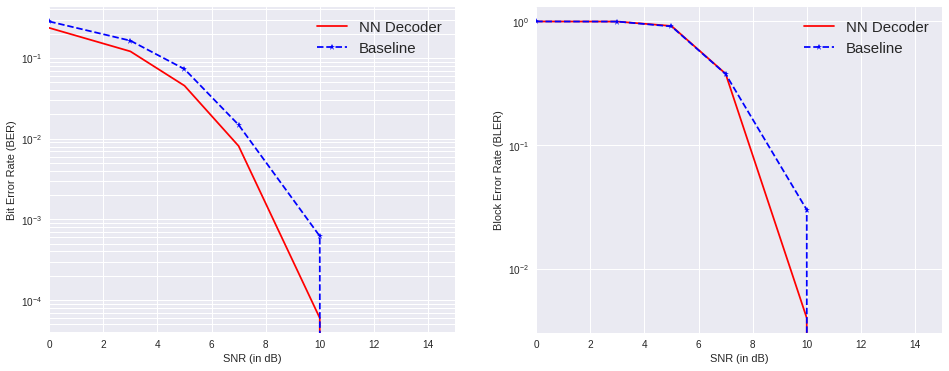

In [42]:
import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
utils.visualize_ber_bler(ax1, ax2, ber_logs, bler_logs, Params.SNR_RANGE)
ax1.semilogy()
ax2.semilogy()